In [1]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Extracts player matches from json files 
file_list = []

folder_path = "./rta_player_data"
files_in_folder = os.listdir(folder_path)

# Filter out only files (excluding directories)
files = [file for file in files_in_folder if os.path.isfile(os.path.join(folder_path, file))]

for file in files:
    file_list.append('./rta_player_data/' + file)


In [3]:
def generate_drafts(user_data):
    battles = pd.read_json(user_data)
    battles = dict(battles.loc["battle_list"])['result_body']
    
    # holds all matches
    data_match = list()

    for x in range(len(battles)):
        
        # generic dict to store all features
        data = dict()

        # extracts hero pick order
        my_list = battles[x]['my_deck']
        enemy_list = battles[x]['enemy_deck']
        hero_deck = my_list["hero_list"]
        enemy_hero_deck = enemy_list["hero_list"]
        
        # checks for matches that do not have hero data
        # and skips that match
        team = battles[x]['teamBettleInfo']
        string_data_team = '{' + team + '}'
        data2 = json.loads(string_data_team)
        my_team_data = data2["my_team"]
        if not my_team_data:
            continue
        
        # extracts match pre bans and which side won
        my_preban = my_list['preban_list']
        enemy_preban = enemy_list['preban_list']
        is_win = battles[x]['iswin']
        
        # extract which user has the first turn
        is_first = 0
        for pick in hero_deck:
            first_pick = pick['first_pick']
            if first_pick == 1:
                is_first = 1
                break
            
        # heroes         
        for i in range(5):
            
            data['main' + str(i+1)] = hero_deck[i]['hero_code']
            data['enemy' + str(i+1)] = enemy_hero_deck[i]['hero_code']
            
        # pre-bans 
        for i in range(2):
            data['main_pre_b' + str(i+1)] = my_preban[i]
            data['enemy_pre_b' + str(i+1)] = enemy_preban[i] 
        
        # post-ban for main
        for i in range(5):
            if hero_deck[i]['ban'] == 1:
                data['main_post_b'] = str(hero_deck[i]['hero_code'])
        
        # post-ban for enemy     
        for i in range(5):
            if enemy_hero_deck[i]['ban'] == 1:
                data['enemy_post_b'] = str(enemy_hero_deck[i]['hero_code']) 
        
        # adds the user with first pick and winner to the match instance    
        data['is_first'] = is_first  
        data['is_win'] = is_win
        
        data_match.append(data)
    
    return data_match

In [4]:
# keep track of each match
drafts_dataset = []
for i in range(len(file_list)):
    res = generate_drafts(file_list[i])
    drafts_dataset.append(res)

# turns the 2d array to 1d and converts to dataframe
collapsed_arr = [item for sublist in drafts_dataset for item in sublist]
dataset = pd.DataFrame(collapsed_arr)


In [5]:
dataset

,main1,enemy1,main2,enemy2,main3,enemy3,main4,enemy4,main5,enemy5,main_pre_b1,enemy_pre_b1,main_pre_b2,enemy_pre_b2,main_post_b,enemy_post_b,is_first,is_win
0,c4144,c1159,c1126,c6017,c2022,c4004,c2047,c2103,c2099,c1137,c2016,c2090,c2109,c2089,c2099,c6017,0,2
1,c4144,c2022,c1159,c2008,c2101,c2050,c4004,c5089,c2099,c2089,c2016,c2090,c2109,c1133,c2099,c2089,0,2
2,c1159,c2089,c4144,c2024,c2022,c2070,c2047,c2009,c2099,c5082,c2016,c2090,c2109,c1133,c4144,c5082,0,2
3,c4144,c1121,c1159,c5089,c2022,c2070,c2047,c1034,c2089,c2079,c2016,c1133,c2109,c6062,c2089,c5089,0,1
4,c4144,c1159,c2022,c2089,c2090,c4004,c2101,c2050,c2047,c1145,c2016,c1133,c2109,c1118,c2047,c2089,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5363,c2109,c4003,c4004,c2070,c2090,c2132,c1055,c2016,c2073,c2027,c1151,c6062,c2089,c2008,c4004,c2132,1,1
5364,c4004,c1159,c2109,c2132,c6037,c2090,c1055,c6062,c2095,c4005,c1151,c2016,c2089,c2089,c2095,c4005,0,2
5365,c4004,c1159,c2109,c2070,c2132,c2090,c1055,c2074,c2073,c2071,c1151,c2016,c2089,c6062,c4004,c2090,0,1
5366,c2008,c1159,c2101,c2090,c2132,c1128,c2019,c4144,c1133,c2009,c1151,c2016,c2089,c2109,c1133,c2090,0,2


In [6]:
# sampled 50 random rows (matches)
rows = dataset.sample(n=50)
dataset_sample = pd.DataFrame(rows)
dataset_sample.reset_index(drop=True, inplace=True)


In [7]:
# checks the user whether they have the first pick and 
# keeps track of the hero picked first by that user
first_picked_col = []
for index, row in dataset_sample.iterrows():
    if row['is_first'] == 1:
        val = row['main1']
        first_picked_col.append(val)
    else:
        val = row['enemy1']
        first_picked_col.append(val)
        
dataset_sample['first_picked'] = first_picked_col

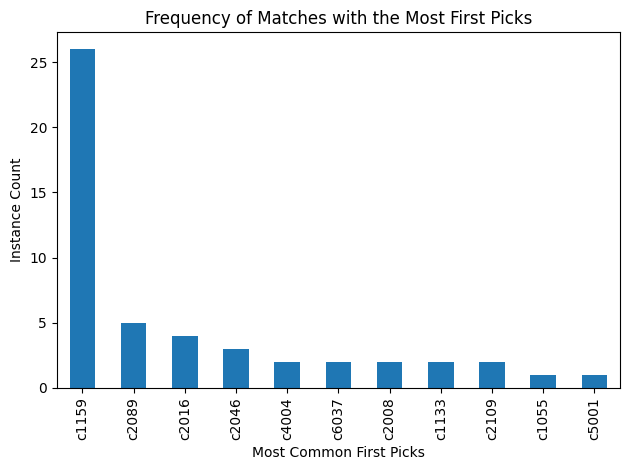

In [8]:
# Plots most common first picks 
graphMostFirstPick = dataset_sample['first_picked'].value_counts()
graphMostFirstPick.plot(kind='bar')
plt.xlabel('Most Common First Picks')
plt.ylabel('Instance Count')
plt.title('Frequency of Matches with the Most First Picks')
plt.tight_layout()
plt.show()

In [9]:
# Specify the file name
csv_file = 'drafts_dataset_sample.csv'

# Write the concatenated DataFrame to a CSV file
dataset_sample.to_csv(csv_file, index=False)



In [10]:
# Specify the file name
whole_dataset_csv_file = 'drafts_dataset.csv'

# Write the concatenated DataFrame to a CSV file
dataset.to_csv(whole_dataset_csv_file, index=False)

In [11]:
first_picked_col_all = []
for index, row in dataset.iterrows():
    if row['is_first'] == 1:
        val = row['main1']
        first_picked_col_all.append(val)
    else:
        val = row['enemy1']
        first_picked_col_all.append(val)
        
dataset['first_picked'] = first_picked_col_all

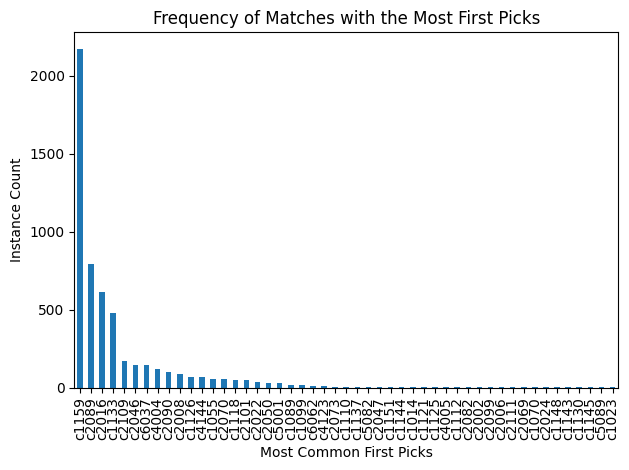

In [12]:
graphMostFirstPick = dataset['first_picked'].value_counts()
graphMostFirstPick.plot(kind='bar')
plt.xlabel('Most Common First Picks')
plt.ylabel('Instance Count')
plt.title('Frequency of Matches with the Most First Picks')
plt.tight_layout()
plt.show()

In [13]:
recommended_fp = [] 
for i in range(1):
    recommended_fp.append(dataset['first_picked'][i])

In [14]:

recommended_fp[0]

'c1159'

In [19]:
def draft_response(hero):
    
    # Main first pick
    if hero == 2:
        return recommended_fp[0]
    
    response = []
    for index, row in dataset.iterrows():
            
        
        # 1 2 response into fp  
        if row['is_first'] == 0 and hero:
            if row['enemy1'] == hero: 
                response1 = row['main1']
                response2 = row['main2']
                response.append([response1, response2])
                responses_df = pd.DataFrame(response)
                responses_df = responses_df.value_counts()[:1]
                output = responses_df.index[0] 
                
                
                
        # 2 3 response into 1 2  
        # if row['is_first'] == 0 and hero:
        #     if row['enemy1'] == hero: 
        #         response1 = row['main1']
        #         response2 = row['main2']
        #         response.append([response1, response2])
        #         responses_df = pd.DataFrame(response)
        #         responses_df = responses_df.value_counts()[:1]
        #         output = responses_df.index[0] 
        else:
            response1 = row['main1']
            response2 = row['main2']
            response.append([response1, response2])
            responses_df = pd.DataFrame(response)
            responses_df = responses_df.value_counts()[:1]
            output = responses_df.index[0]
        #     print("sdasdasdfds")
            # val = row['enemy2']
            # first_picked_col_all.append(val)
            
    return output
        


In [21]:
first_pick_main = 2

draft_response("c0047")

('c1159', 'c2008')

In [ ]:
res.index[0]

('c2089', 'c2109')